## Kaggle – DataTops®
Luismi ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Luismi a mejorar ese modelo?

## Métrica: 
Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión; RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## Librerías

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_regression
import urllib.request
import re

## Datos

In [2]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("./data/train.csv", index_col=0)
df.index.name = None

## Exploración de los datos

In [3]:
df.drop_duplicates(subset=None, keep='first', inplace=True)

## Procesado de datos

Nuestro target es la columna `Price_in_euros`

In [4]:
target = df["Price_in_euros"]

In [5]:
df["inches"]=df.Inches.astype(float)
df["ram_gb"]=df["Ram"].str.replace("GB","").astype(int)
df["weight_kg"]=df["Weight"].str.replace("kg","").astype(float)
df = pd.get_dummies(df, columns=['TypeName'], prefix='Type')

In [6]:
# Función para extraer el número de memoria y convertir a GB
def convert_to_gb(memory):
    # Extraemos el número de memoria, ignorando texto como 'GB', 'TB', etc.
    try:
        memory_value = ''.join([char for char in memory if char.isdigit() or char == '.'])
        memory_value = float(memory_value)
        # Si la unidad es TB, la convertimos a GB
        if 'TB' in memory:
            return memory_value * 1024  # 1 TB = 1024 GB
        else:
            return memory_value  # Si ya está en GB, lo dejamos como está
    except ValueError:
        return np.nan  # Si no se puede extraer un valor numérico, devolvemos NaN

# Función para procesar cada valor de la columna 'Memory' que pueda tener múltiples memorias
def process_memory(memory):
    ssd, hdd, flash, hybrid = 0, 0, 0, 0  # Inicializamos las variables de cada tipo de memoria

    # Separamos los valores si hay un '+'
    memories = memory.split(' + ') if isinstance(memory, str) else []
    
    for mem in memories:
        # Revisamos el tipo de memoria y aplicamos la conversión a GB
        if 'SSD' in mem:
            ssd += convert_to_gb(mem)
        elif 'HDD' in mem:
            hdd += convert_to_gb(mem)
        elif 'Flash Storage' in mem:
            flash += convert_to_gb(mem)
        elif 'Hybrid' in mem:
            hybrid += convert_to_gb(mem)

    return ssd, hdd, flash, hybrid

# Aplicamos la función para crear nuevas columnas
df[['SSD_GB', 'HDD_GB', 'Flash_Storage_GB', 'Hybrid_GB']] = df['Memory'].apply(lambda x: pd.Series(process_memory(x)))

"""
# Sumar los valores de las columnas
ssd_sum = df['SSD_GB'].sum()
hdd_sum = df['HDD_GB'].sum()
flash_storage_sum = df['Flash_Storage_GB'].sum()
hybrid_sum = df['Hybrid_GB'].sum()

# Mostrar los resultados
print(f"Suma total de SSD en GB: {ssd_sum} GB")
print(f"Suma total de HDD en GB: {hdd_sum} GB")
print(f"Suma total de Flash Storage en GB: {flash_storage_sum} GB")
print(f"Suma total de Hybrid en GB: {hybrid_sum} GB")
"""


'\n# Sumar los valores de las columnas\nssd_sum = df[\'SSD_GB\'].sum()\nhdd_sum = df[\'HDD_GB\'].sum()\nflash_storage_sum = df[\'Flash_Storage_GB\'].sum()\nhybrid_sum = df[\'Hybrid_GB\'].sum()\n\n# Mostrar los resultados\nprint(f"Suma total de SSD en GB: {ssd_sum} GB")\nprint(f"Suma total de HDD en GB: {hdd_sum} GB")\nprint(f"Suma total de Flash Storage en GB: {flash_storage_sum} GB")\nprint(f"Suma total de Hybrid en GB: {hybrid_sum} GB")\n'

In [7]:
def extraer_frecuencia(cpu_name):
    # Busca un patrón que coincida con un número decimal seguido de 'GHz'
    match = re.search(r'(\d+(\.\d+)?)\s*GHz', cpu_name)
    if match:
        # Devuelve la frecuencia como un número de punto flotante
        return float(match.group(1))
    else:
        return None

In [8]:
df['Frecuencia'] = df['Cpu'].apply(extraer_frecuencia)

In [9]:
# Función para asignar valores según el nombre del Cpu
def asignar_valor(Cpu):
    if 'Intel Core i7' in Cpu:
        return 4
    elif 'Intel Core i5' in Cpu:
        return 3
    elif 'Intel' in Cpu:
        return 2
    elif 'AMD' in Cpu:
        return 1
    else:
        return None  # O cualquier valor que desees para los casos que no coinciden

# Aplicar la función a la columna 'Cpu' y crear una nueva columna 'valor'
df['valor_CPU'] = df['Cpu'].apply(asignar_valor)

In [10]:
## Clasificar tipos de pantalla
# Lista de términos a buscar
terms = ["Full HD", "Touchscreen", "IPS", "4K", "Retina", "Quad HD"]

# Función para verificar la presencia de cada término
def check_terms(resolution):
    return [1 if re.search(term, resolution, re.IGNORECASE) else 0 for term in terms]

# Aplicamos la función para crear nuevas columnas
df[terms] = df['ScreenResolution'].apply(lambda x: pd.Series(check_terms(x)))



In [11]:
def extract_resolution(resolution):
    match = re.search(r'(\d+)x(\d+)', resolution)
    if match:
        return int(match.group(1)), int(match.group(2))
    return np.nan, np.nan

# Función para extraer la descripción sin las dimensiones
def extract_description(resolution):
    return re.sub(r'\d+x\d+', '', resolution).strip()



In [12]:
def mods_pantalla(df):
    # Aplicamos la función a la columna 'ScreenResolution'
    df[['Width', 'Height']] = df['ScreenResolution'].apply(lambda x: pd.Series(extract_resolution(x)))

    # Calculamos el PPI
    df['PPI'] = ((df['Width']**2 + df['Height']**2) ** 0.5) / df['Inches']

    df.drop(columns=["Width","Height","inches"], inplace=True)

    return df

In [13]:
df_=mods_pantalla(df)
df

,Company,Product,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,...,Hybrid_GB,Frecuencia,valor_CPU,Full HD,Touchscreen,IPS,4K,Retina,Quad HD,PPI
755,HP,250 G6,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,...,0.0,2.0,2,1,0,0,0,0,0,141.211998
618,Dell,Inspiron 7559,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,...,0.0,2.6,4,1,0,0,0,0,0,141.211998
909,HP,ProBook 450,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,...,0.0,2.7,4,1,0,0,0,0,0,141.211998
2,Apple,Macbook Air,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,...,0.0,1.8,3,0,0,0,0,0,0,127.677940
286,Dell,Inspiron 3567,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,...,0.0,2.0,2,1,0,0,0,0,0,141.211998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Dell,Inspiron 5570,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,AMD Radeon 530,Windows 10,2.2kg,...,0.0,1.6,3,1,0,0,0,0,0,141.211998
1160,HP,Spectre Pro,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.48kg,...,0.0,2.4,3,1,1,0,0,0,0,165.632118
78,Lenovo,IdeaPad 320-15IKBN,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,2TB HDD,Intel HD Graphics 620,No OS,2.2kg,...,0.0,2.5,3,1,0,0,0,0,0,141.211998
23,HP,255 G6,15.6,1366x768,AMD E-Series E2-9000e 1.5GHz,4GB,500GB HDD,AMD Radeon R2,No OS,1.86kg,...,0.0,1.5,1,0,0,0,0,0,0,100.454670


-----------------------------------------------------------------------------------------------------------------

## Modelado

### 1. Definir X e y

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 755 to 229
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Company                  891 non-null    object 
 1   Product                  891 non-null    object 
 2   Inches                   891 non-null    float64
 3   ScreenResolution         891 non-null    object 
 4   Cpu                      891 non-null    object 
 5   Ram                      891 non-null    object 
 6   Memory                   891 non-null    object 
 7   Gpu                      891 non-null    object 
 8   OpSys                    891 non-null    object 
 9   Weight                   891 non-null    object 
 10  Price_in_euros           891 non-null    float64
 11  ram_gb                   891 non-null    int32  
 12  weight_kg                891 non-null    float64
 13  Type_2 in 1 Convertible  891 non-null    bool   
 14  Type_Gaming              891 

In [15]:
"""
X = df.drop(['Price_in_euros',"Weight","Inches","Ram"], axis=1)
y = df['Price_in_euros'].copy()
X.shape
"""

'\nX = df.drop([\'Price_in_euros\',"Weight","Inches","Ram"], axis=1)\ny = df[\'Price_in_euros\'].copy()\nX.shape\n'

In [ ]:
numericas=["ram_gb","weight_kg","SSD_GB","HDD_GB","Flash_Storage_GB","Hybrid_GB","Frecuencia","PPI"]

In [16]:
X = df.iloc[:,11:].copy()
y = df["Price_in_euros"].copy()

In [17]:
X.describe()

,ram_gb,weight_kg,SSD_GB,HDD_GB,Flash_Storage_GB,Hybrid_GB,Frecuencia,valor_CPU,Full HD,Touchscreen,IPS,4K,Retina,Quad HD,PPI
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,8.316498,2.028358,186.796857,408.722783,5.135802,5.167228,2.289203,3.085297,0.643098,0.142536,0.273850,0.029181,0.013468,0.024691,146.487419
std,5.057284,0.669647,194.192509,518.072311,30.688624,70.540275,0.515258,0.902878,0.479355,0.349796,0.446183,0.168407,0.115332,0.155270,43.330763
min,2.000000,0.690000,0.000000,0.000000,0.000000,0.000000,0.900000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.583402
25%,4.000000,1.490000,0.000000,0.000000,0.000000,0.000000,1.800000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,127.335675
50%,8.000000,2.040000,256.000000,0.000000,0.000000,0.000000,2.500000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,141.211998
75%,8.000000,2.300000,256.000000,1024.000000,0.000000,0.000000,2.700000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,157.350512
max,64.000000,4.700000,1024.000000,2048.000000,512.000000,1024.000000,3.600000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,352.465147


In [18]:
X.shape

(891, 21)

In [19]:
X.head()

,ram_gb,weight_kg,Type_2 in 1 Convertible,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,SSD_GB,HDD_GB,...,Hybrid_GB,Frecuencia,valor_CPU,Full HD,Touchscreen,IPS,4K,Retina,Quad HD,PPI
755,8,1.86,False,False,False,True,False,False,256.0,0.0,...,0.0,2.0,2,1,0,0,0,0,0,141.211998
618,16,2.59,False,True,False,False,False,False,0.0,1024.0,...,0.0,2.6,4,1,0,0,0,0,0,141.211998
909,8,2.04,False,False,False,True,False,False,0.0,1024.0,...,0.0,2.7,4,1,0,0,0,0,0,141.211998
2,8,1.34,False,False,False,False,True,False,0.0,0.0,...,0.0,1.8,3,0,0,0,0,0,0,127.677940
286,4,2.25,False,False,False,True,False,False,0.0,1024.0,...,0.0,2.0,2,1,0,0,0,0,0,141.211998


In [20]:
y.shape

(891,)

In [21]:
y.head()

755    539.00
618    879.01
909    900.00
2      898.94
286    428.00
Name: Price_in_euros, dtype: float64

### 2. Dividir X_train, X_test, y_train, y_test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [23]:
X_train

,ram_gb,weight_kg,Type_2 in 1 Convertible,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,SSD_GB,HDD_GB,...,Hybrid_GB,Frecuencia,valor_CPU,Full HD,Touchscreen,IPS,4K,Retina,Quad HD,PPI
112,8,1.58,False,False,False,True,False,False,256.0,0.0,...,0.0,2.7,4,1,0,1,0,0,0,157.350512
13,16,1.83,False,False,False,False,True,False,256.0,0.0,...,0.0,2.8,4,0,0,1,0,1,0,220.534624
1190,4,2.20,False,False,False,True,False,False,0.0,500.0,...,0.0,1.6,2,0,0,0,0,0,0,100.454670
55,4,2.40,False,False,False,True,False,False,0.0,1024.0,...,0.0,2.4,2,0,0,0,0,0,0,100.454670
1043,8,2.63,False,False,False,True,False,False,256.0,0.0,...,0.0,2.5,3,1,0,0,0,0,0,127.335675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,8,1.94,False,False,False,True,False,False,0.0,2048.0,...,0.0,1.6,2,0,0,0,0,0,0,111.935204
336,8,2.70,False,True,False,False,False,False,256.0,1024.0,...,0.0,2.8,4,1,0,0,0,0,0,127.335675
20,8,1.22,False,False,False,False,True,False,128.0,0.0,...,0.0,1.6,3,1,1,1,0,0,0,165.632118
876,4,2.07,False,False,False,True,False,False,0.0,500.0,...,0.0,2.3,3,1,0,0,0,0,0,141.211998


In [24]:
y_train

112     1480.00
13      2439.97
1190     369.00
55       384.00
1043    1080.00
         ...   
578      389.00
336     1199.00
20       979.00
876      910.00
418     1943.00
Name: Price_in_euros, Length: 712, dtype: float64

### 3. Baseline de modelos


In [25]:
dfmodel = RandomForestRegressor()

dfmodel.fit(X_train,y_train)

RandomForestRegressor()

In [26]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [27]:
# Inicializar GridSearchCV
grid_search = GridSearchCV(estimator=dfmodel, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ajustar el modelo a los datos
grid_search.fit(X, y)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros: {grid_search.best_params_}")


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


C:\Users\joser\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
673 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\joser\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\joser\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\joser\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 436, in _validate_params
    va

Mejores parámetros: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [28]:
y_pred=dfmodel.predict(X_test)

### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de ``RMSE``.

In [29]:
RMSE = root_mean_squared_error(y_test,y_pred)
RMSE

325.49702044315694

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [30]:
X_pred = pd.read_csv("data/test.csv", index_col=0)
X_pred.index.name = None
X_pred.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg


In [31]:
X_pred.tail()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
820,MSI,GE72MVR 7RG,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg
948,Toshiba,Tecra Z40-C-12X,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg
483,Dell,Precision M5520,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg
1017,HP,Probook 440,Notebook,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg
421,Asus,ZenBook Flip,2 in 1 Convertible,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.27kg


In [32]:
X_pred["inches"]=X_pred.Inches.astype(float)
X_pred["ram_gb"]=X_pred["Ram"].str.replace("GB","").astype(int)
X_pred["weight_kg"]=X_pred["Weight"].str.replace("kg","").astype(float)
X_pred = pd.get_dummies(X_pred, columns=['TypeName'], prefix='Type')

In [33]:
# Función para extraer el número de memoria y convertir a GB
def convert_to_gb(memory):
    # Extraemos el número de memoria, ignorando texto como 'GB', 'TB', etc.
    try:
        memory_value = ''.join([char for char in memory if char.isdigit() or char == '.'])
        memory_value = float(memory_value)
        # Si la unidad es TB, la convertimos a GB
        if 'TB' in memory:
            return memory_value * 1024  # 1 TB = 1024 GB
        else:
            return memory_value  # Si ya está en GB, lo dejamos como está
    except ValueError:
        return np.nan  # Si no se puede extraer un valor numérico, devolvemos NaN

# Función para procesar cada valor de la columna 'Memory' que pueda tener múltiples memorias
def process_memory(memory):
    ssd, hdd, flash, hybrid = 0, 0, 0, 0  # Inicializamos las variables de cada tipo de memoria

    # Separamos los valores si hay un '+'
    memories = memory.split(' + ') if isinstance(memory, str) else []
    
    for mem in memories:
        # Revisamos el tipo de memoria y aplicamos la conversión a GB
        if 'SSD' in mem:
            ssd += convert_to_gb(mem)
        elif 'HDD' in mem:
            hdd += convert_to_gb(mem)
        elif 'Flash Storage' in mem:
            flash += convert_to_gb(mem)
        elif 'Hybrid' in mem:
            hybrid += convert_to_gb(mem)

    return ssd, hdd, flash, hybrid

# Aplicamos la función para crear nuevas columnas
X_pred[['SSD_GB', 'HDD_GB', 'Flash_Storage_GB', 'Hybrid_GB']] = X_pred['Memory'].apply(lambda x: pd.Series(process_memory(x)))



In [34]:
X_pred['Frecuencia'] = X_pred['Cpu'].apply(extraer_frecuencia)


In [35]:
# Aplicar la función a la columna 'Cpu' y crear una nueva columna 'valor'
X_pred['valor_CPU'] = X_pred['Cpu'].apply(asignar_valor)

In [36]:
X_pred[terms] = X_pred['ScreenResolution'].apply(lambda x: pd.Series(check_terms(x)))

# Mostramos las primeras filas del DataFrame actualizado
df.head()

,Company,Product,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,...,Hybrid_GB,Frecuencia,valor_CPU,Full HD,Touchscreen,IPS,4K,Retina,Quad HD,PPI
755,HP,250 G6,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,...,0.0,2.0,2,1,0,0,0,0,0,141.211998
618,Dell,Inspiron 7559,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,...,0.0,2.6,4,1,0,0,0,0,0,141.211998
909,HP,ProBook 450,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,...,0.0,2.7,4,1,0,0,0,0,0,141.211998
2,Apple,Macbook Air,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,...,0.0,1.8,3,0,0,0,0,0,0,127.677940
286,Dell,Inspiron 3567,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,...,0.0,2.0,2,1,0,0,0,0,0,141.211998


In [37]:
X_pred=mods_pantalla(X_pred)

In [38]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Company                  391 non-null    object 
 1   Product                  391 non-null    object 
 2   Inches                   391 non-null    float64
 3   ScreenResolution         391 non-null    object 
 4   Cpu                      391 non-null    object 
 5   Ram                      391 non-null    object 
 6   Memory                   391 non-null    object 
 7   Gpu                      391 non-null    object 
 8   OpSys                    391 non-null    object 
 9   Weight                   391 non-null    object 
 10  ram_gb                   391 non-null    int32  
 11  weight_kg                391 non-null    float64
 12  Type_2 in 1 Convertible  391 non-null    bool   
 13  Type_Gaming              391 non-null    bool   
 14  Type_Netbook             391 

In [39]:
X_pred = X_pred.iloc[:,10:].copy()

 ## 2. Replicar el procesado para ``test.csv``

In [40]:
X_pred

,ram_gb,weight_kg,Type_2 in 1 Convertible,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,SSD_GB,HDD_GB,...,Hybrid_GB,Frecuencia,valor_CPU,Full HD,Touchscreen,IPS,4K,Retina,Quad HD,PPI
209,16,2.400,False,True,False,False,False,False,512.0,0.0,...,0.0,2.8,4.0,1,0,0,0,0,0,141.211998
1281,4,2.400,False,False,False,True,False,False,0.0,500.0,...,0.0,1.6,2.0,0,0,0,0,0,0,100.454670
1168,4,1.900,False,False,False,True,False,False,0.0,1024.0,...,0.0,2.0,2.0,0,0,0,0,0,0,100.454670
1231,8,2.191,True,False,False,False,False,False,256.0,0.0,...,0.0,2.5,3.0,1,1,1,0,0,0,141.211998
1020,4,1.950,False,False,False,True,False,False,256.0,0.0,...,0.0,2.5,3.0,1,0,0,0,0,0,157.350512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,16,2.900,False,True,False,False,False,False,512.0,1024.0,...,0.0,2.8,4.0,1,0,0,0,0,0,127.335675
948,4,1.470,False,False,False,True,False,False,128.0,0.0,...,0.0,2.3,3.0,1,0,1,0,0,0,157.350512
483,8,1.780,False,False,False,False,False,True,256.0,0.0,...,0.0,2.8,4.0,1,0,0,0,0,0,141.211998
1017,4,1.640,False,False,False,True,False,False,0.0,500.0,...,0.0,2.5,3.0,0,0,0,0,0,0,111.935204


In [41]:
predictions_submit = dfmodel.predict(X_pred)
predictions_submit

array([1479.16723333,  313.61042338,  377.5008    ,  927.25563333,
        979.9184    ,  471.68706667,  884.01234167,  947.47333333,
       1371.5129    ,  303.4259    , 2500.42428238, 1344.956     ,
        505.46948333, 1587.0673    ,  805.19867167,  809.68371667,
       1954.6914    , 1533.6647    , 1529.4953    ,  637.121     ,
       1492.889     ,  271.5729    ,  655.54823333, 1712.8474    ,
        496.41215714,  661.46585   ,  494.8811    ,  955.4091    ,
       2433.99405   , 1026.2428    , 2121.44678429,  336.18915   ,
        784.72574   , 2913.1758    , 2053.5546    , 1994.77799206,
        665.39464286, 1506.9514    ,  946.57410238, 1586.875     ,
        722.2541    , 1016.2015    ,  537.9819    , 1136.4194    ,
       1197.34353333, 1142.48513333, 1005.59843333,  502.4999    ,
        785.18918167,  483.30913333, 2036.6949    ,  678.65343202,
       1184.58452381,  850.30442833, 1773.7325    , 1532.9662    ,
        645.8885    ,  894.33923333, 1006.6962    ,  554.7213 

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [42]:
# ¿Qué opináis?
# ¿Sí, no?

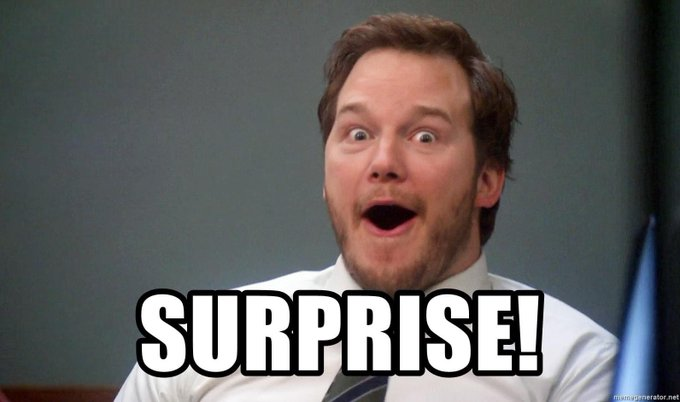

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [43]:
sample = pd.read_csv("data/sample_submission.csv")

In [44]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [45]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [46]:
#¿Cómo creamos la submission?
submission = pd.DataFrame({"laptop_ID":X_pred.index,"Price_in_euros":predictions_submit})

In [47]:
submission.head()

,laptop_ID,Price_in_euros
0,209,1479.167233
1,1281,313.610423
2,1168,377.500800
3,1231,927.255633
4,1020,979.918400


In [48]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [49]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [50]:
chequeador(submission)

You're ready to submit!
